# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgbm
import time
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse

In [ ]:
data = pd.read_csv('/datasets/autos.csv')

In [ ]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [ ]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [ ]:
(data.isna().sum()/data.shape[0]).round(2)
# смотрим пропуски в процентом отношении

DateCrawled          0.00
Price                0.00
VehicleType          0.11
RegistrationYear     0.00
Gearbox              0.06
Power                0.00
Model                0.06
Kilometer            0.00
RegistrationMonth    0.00
FuelType             0.09
Brand                0.00
Repaired             0.20
DateCreated          0.00
NumberOfPictures     0.00
PostalCode           0.00
LastSeen             0.00
dtype: float64

In [ ]:
category_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType','Brand','Repaired']

Вынесем столбцы с категориальными данными в отдельный список

In [ ]:
data[category_columns].isna().sum()

VehicleType    37490
Gearbox        19833
Model          19705
FuelType       32895
Brand              0
Repaired       71154
dtype: int64

In [ ]:
data[category_columns] = data[category_columns].fillna('unknown')



 т.к. пропуски в данных заполнить невозможно и нельзя их удалить,  т.к. недостаток исторических данных,
мы заполним "неизвестным", тем более, что пропуски в категориальных данных

In [ ]:
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [ ]:
data = data.drop(['DateCrawled',
                  'NumberOfPictures',
                  'PostalCode',
                  'LastSeen',
                  'DateCreated',
                  'RegistrationMonth'], axis = 1)


удалим не влияющие на обучение столбцы

In [ ]:
data.duplicated().sum()

45040

проверяем на дубликаты, их очень мало

Построим гистограммы распределения некоторых категориальных признаков, для выявления аномалий

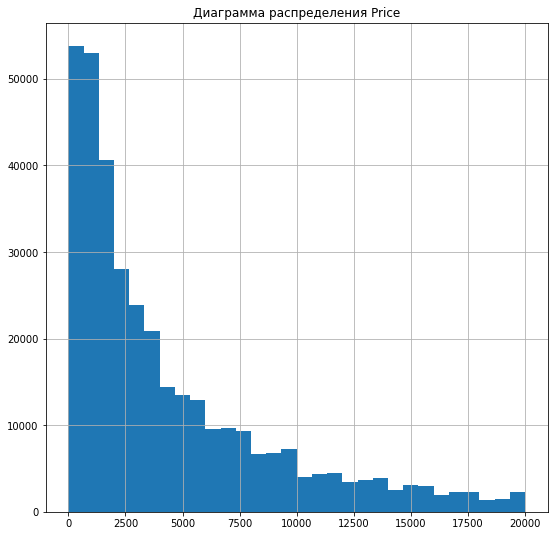

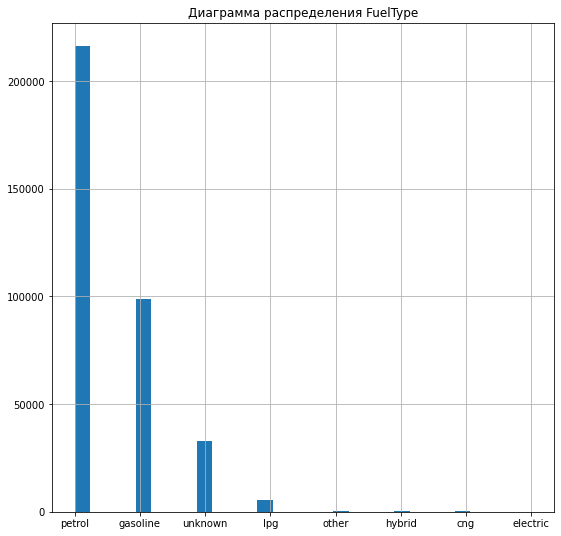

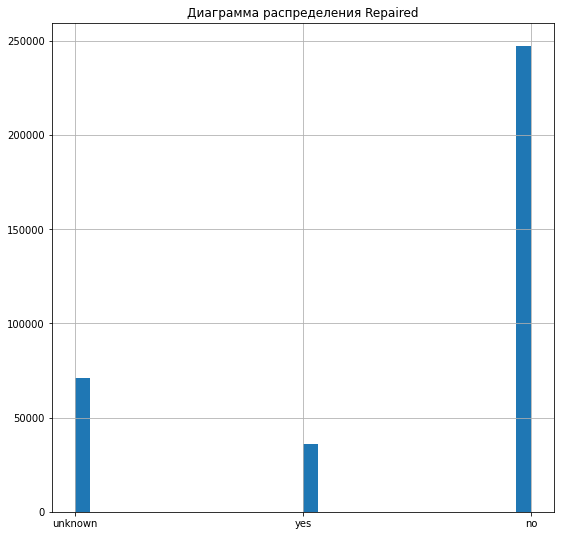

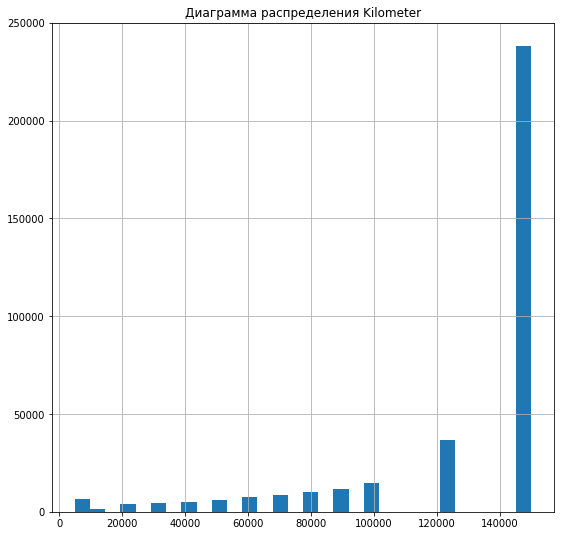

In [ ]:
columns = ['Price', 'FuelType','Repaired', 'Kilometer']
for col in columns:
    plt.figure(figsize=(9, 9))
    plt.title(f'Диаграмма распределения {col}')
    data[col].hist(bins=30)
    plt.show()

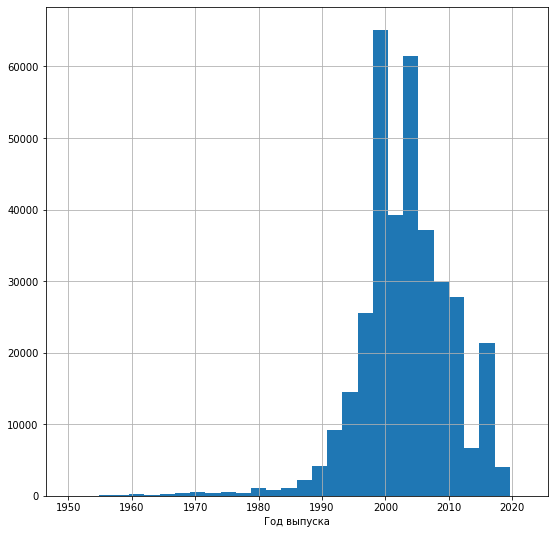

In [ ]:
data['RegistrationYear'].hist(figsize=(9, 9), bins=30, range=(1950, 2022))
plt.xlabel('Год выпуска')
plt.show()
# рассмотрим отдельно распределение года выпуска

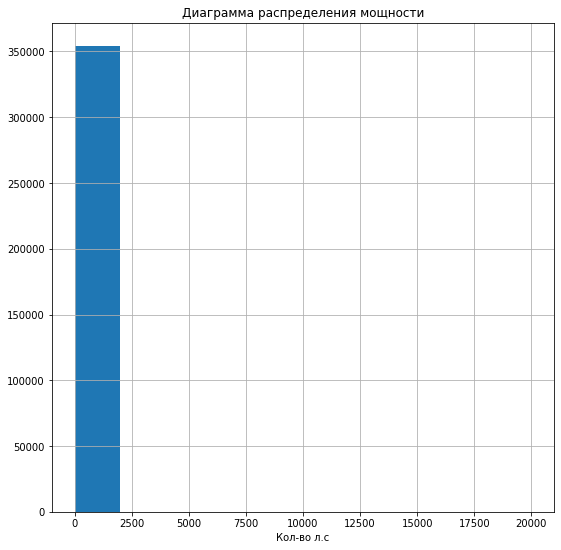

In [ ]:
data['Power'].hist(figsize=(9,9))
plt.title(f'Диаграмма распределения мощности')
plt.xlabel('Кол-во л.с')
plt.show()

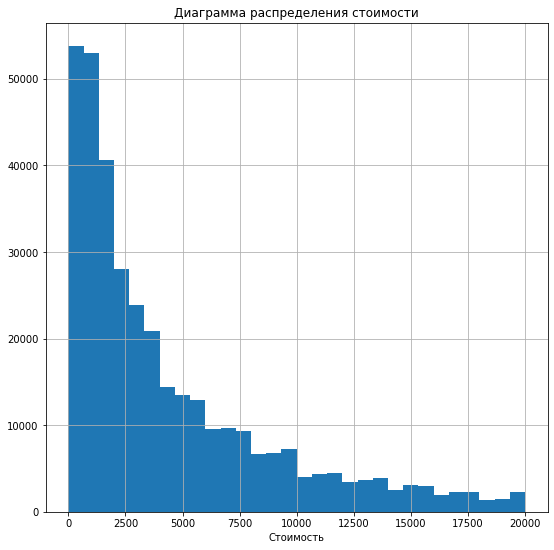

In [ ]:
data['Price'].hist( figsize=(9,9), bins=30)
plt.title(f'Диаграмма распределения стоимости')
plt.xlabel('Стоимость')
plt.show()

В колонках цена, год выпуска и мощность, много околонулевых значений - выбросы, от них придется избавится, т.к. могут плохо влиять на обучение модели. Так же есть и околонулевые значения в столбце мощность и выбросы в виде значений свыше 1000 лс. Их придется корректировать, есть предположение, что при создании анкеты потерялась точка, и значения убежали далеко за пределы.
Поэтому удалим из таблицы данные с ценой до 100 евро, и нулевую мощность

In [ ]:
data = data.query('Price>100')
data = data.query('Power !=0')
data = data.query('1910<RegistrationYear<2022')
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


**Мини вывод**

Мы загрузили и посмотрели данные, оценили пропуски, приняли решение не трогать их,  а заменить на неизвестное, т.к. мы имеем недостаток исторических данных, или их просто не указали при создании анкеты. Удалили ненужные для обучения столбцы (дата создания анкеты, кол-во фото, индекс владельца, последняя активность, месяц регистрации ТС, т.к. более важен год регистрации, чем месяц).  Построили гистограммы по некоторым столбцам, в основном продаются машины выпуска от 1999 до 2005 года, можно по разному описать эти события, что новоиспеченные водители покупают старые машины, как первую, и потом продают их, очень много машин без ремонта, либо ремонтировались, но об этом умолчали. На рынке чаще продаются машины с пробегом более 150 т.км. В целом больше замечаний нет для дальнейшей работы и обучения модели.

## Обучение моделей

Выделим признаки для дальнейшего обучения моделей

In [ ]:
features = data.drop(['Price'], axis=1)
target = data['Price']



Делим выборку на обучающую и тестовую

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size = 0.2,
                                                                            random_state=12345)


In [ ]:
print(features_train.shape[0])
print(features_test.shape[0])
print(target_train.shape[0])
print(target_test.shape[0])

244267
61067
244267
61067


Создадим кросс валидационную модель

In [ ]:
cv = KFold(n_splits = 3, shuffle= True, random_state = 12345 )

создаем функцию, которая на вход получает данные с выборок и лучшие параметры для обучения, на выходе выдает время обучения,
    #время редсказания и результат метрики по моделям и кросс валидацией.

In [ ]:
def model_select(model, features_train, target_train, best_score):
    start = time.time()
    model.fit(features_train, target_train)
    train_time = time.time() - start

    start = time.time()
    predicted = model.predict(features_train)
    predicted_time = time.time()-start
    rmse = mse(target_train, predicted)**0.5
    cv_rmse = np.sqrt(-1*best_score)
    return train_time, predicted_time, rmse, cv_rmse

In [ ]:
features_train['VehicleType'] = features_train['VehicleType'].astype('category')
features_train['Gearbox'] = features_train['Gearbox'].astype('category')
features_train['Model'] = features_train['Model'].astype('category')
features_train['FuelType'] = features_train['FuelType'].astype('category')
features_train['Brand'] = features_train['Brand'].astype('category')
features_train['Repaired'] = features_train['Repaired'].astype('category')

features_test['VehicleType'] = features_test['VehicleType'].astype('category')
features_test['Gearbox'] = features_test['Gearbox'].astype('category')
features_test['Model'] = features_test['Model'].astype('category')
features_test['FuelType'] = features_test['FuelType'].astype('category')
features_test['Brand'] = features_test['Brand'].astype('category')
features_test['Repaired'] = features_test['Repaired'].astype('category')

/tmp/ipykernel_86/199925141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train['VehicleType'] = features_train['VehicleType'].astype('category')
/tmp/ipykernel_86/199925141.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train['Gearbox'] = features_train['Gearbox'].astype('category')
/tmp/ipykernel_86/199925141.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

**RandomForest**

In [ ]:
encoder = OrdinalEncoder()
rf_train = features_train.copy()

for i in category_columns:
    rf_train[i]  = encoder.fit_transform(rf_train)


rf = RandomForestRegressor(random_state = 12345)
hyp_params = {
    'max_depth' : [1, 10, 1],
    'n_estimators' : [10, 100, 10]
}

grid_rf = GridSearchCV(rf, hyp_params, scoring='neg_mean_squared_error', verbose=True, cv=cv)


In [ ]:
%%time
grid_rf.fit(rf_train, target_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
CPU times: user 1min 55s, sys: 314 ms, total: 1min 56s
Wall time: 1min 56s


GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [1, 10, 1],
                         'n_estimators': [10, 100, 10]},
             scoring='neg_mean_squared_error', verbose=True)

In [ ]:
grid_rf.best_params_

{'max_depth': 10, 'n_estimators': 100}

In [ ]:
grid_rf_rmse = np.sqrt(-1*grid_rf.best_score_)
grid_rf_rmse

2018.3096614545045

**LightGBM**

In [ ]:
lgbm = LGBMRegressor(boosting_type='gbdt', random_state = 12345)
params = {'learning_rate': np.logspace(-3, 0 ,5),
         'n_estimators' : [40, 60],
         'num_leaves' : [31, 41, 51]
}

grid_lgbm = GridSearchCV(lgbm, params, scoring='neg_mean_squared_error', verbose=True, cv=cv)

In [ ]:
%%time
grid_lgbm.fit(features_train, target_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
CPU times: user 17min 7s, sys: 18.3 s, total: 17min 25s
Wall time: 17min 34s


GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             estimator=LGBMRegressor(random_state=12345),
             param_grid={'learning_rate': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ]),
                         'n_estimators': [40, 60], 'num_leaves': [31, 41, 51]},
             scoring='neg_mean_squared_error', verbose=True)

In [ ]:
grid_lgbm.best_params_

{'learning_rate': 0.1778279410038923, 'n_estimators': 60, 'num_leaves': 51}

In [ ]:
grid_lgbm_rmse = np.sqrt(-1*grid_lgbm.best_score_)
grid_lgbm_rmse


1613.9778323288701

In [ ]:
cb_reg = CatBoostRegressor(random_seed = 12345,
                          loss_function = 'RMSE',
                          silent = True,
                          cat_features = category_columns)
params = {'learning_rate' : np.logspace(-3, 0, 5),
           'iterations' : [40, 60],
           'depth' : [d for d in range(2, 11)]
}

grid_cb_reg = GridSearchCV(cb_reg, params, cv=cv, scoring = 'neg_mean_squared_error', verbose=10)

In [ ]:
%%time
grid_cb_reg.fit(features_train, target_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV 1/3; 1/90] START depth=2, iterations=40, learning_rate=0.001................
[CV 1/3; 1/90] END depth=2, iterations=40, learning_rate=0.001; total time=   2.2s
[CV 2/3; 1/90] START depth=2, iterations=40, learning_rate=0.001................
[CV 2/3; 1/90] END depth=2, iterations=40, learning_rate=0.001; total time=   2.3s
[CV 3/3; 1/90] START depth=2, iterations=40, learning_rate=0.001................
[CV 3/3; 1/90] END depth=2, iterations=40, learning_rate=0.001; total time=   2.1s
[CV 1/3; 2/90] START depth=2, iterations=40, learning_rate=0.005623413251903491.
[CV 1/3; 2/90] END depth=2, iterations=40, learning_rate=0.005623413251903491; total time=   2.4s
[CV 2/3; 2/90] START depth=2, iterations=40, learning_rate=0.005623413251903491.
[CV 2/3; 2/90] END depth=2, iterations=40, learning_rate=0.005623413251903491; total time=   2.1s
[CV 3/3; 2/90] START depth=2, iterations=40, learning_rate=0.005623413251903491.
[CV 3/3

GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f7ac3a77f40>,
             param_grid={'depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'iterations': [40, 60],
                         'learning_rate': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ])},
             scoring='neg_mean_squared_error', verbose=10)

In [ ]:
grid_cb_reg.best_params_

{'depth': 10, 'iterations': 60, 'learning_rate': 0.1778279410038923}

In [ ]:
grid_cb_reg_rmse = np.sqrt(-1*grid_cb_reg.best_score_)
grid_cb_reg_rmse

1686.8798816986887

 Метрика RMSE на обучающей выборке лучше у модели lightgbm, и составляет 1613,977

## Анализ моделей

In [ ]:
# создадим список обученных моделей для построения DataFrame, в список добавляем функцию подсчета предсказаний и метрики rmse

models = []

In [ ]:
models.append(model_select(grid_rf.best_estimator_,
                           rf_train,
                           target_train,
                           grid_rf.best_score_)
)

In [ ]:
models.append(model_select(grid_lgbm.best_estimator_,
                           features_train,
                           target_train,
                           grid_lgbm.best_score_)
)



In [ ]:
models.append(model_select(grid_cb_reg.best_estimator_,
                           features_train,
                           target_train,
                           grid_cb_reg.best_score_)
)


In [ ]:
final = pd.DataFrame(data = models,
                     index = ['RandomForest', 'LightGBM', 'CatBoost'],
                     columns = ['training_time', 'predict_time', 'RMSE', 'RMSE_CV']
)

In [ ]:
display(final)

,training_time,predict_time,RMSE,RMSE_CV
RandomForest,29.352521,2.316273,1959.350463,2018.309661
LightGBM,135.551515,1.700873,1535.258123,1613.977832
CatBoost,9.951276,0.206192,1641.364303,1686.879882


Проверим лучшую модель LGBM на тестовой выборке

In [ ]:
best_model = LGBMRegressor()
best_model.fit(features_train, target_train,eval_metric='rmse')
best_predicted = best_model.predict(features_test)
rmse = mse(target_test, best_predicted)**0.5
print(rmse)

1625.8001960147026


Модель LGBM на тестовой выборке показала результат почти такой же, как и на кросс валидационной. Значит все расчеты выполнены верно!

**Вывод**

Мы выполнили обработку данных по анкетам автомобилей с пробегом, отдельно выделили столбцы с категорийными данными, которые пригодятся нам для обучения модели, в данных столбцах было большое кол-во пропусков, из-за нехватки исторических данных или по какой либо технической ошибке они появились мы узнать не можем, поэтому пропуски заполнили unknown.


Построили графики с распределением разных категорий, выявили какие машины в основном продаются, с каким пробегом и какого года выпуска. На рынке в основном машины околонулевых годов выпуска(2000-х), с пробегами свыше 140 т.км., большинство машин с бензиновыми двигателями.


Далее в обучении моделей применили кодировщик OrdinalEncoder и встроенный кодировщик модели LGBM .  Далее создали функцию для обучния моделей, вычисления предсказаний и метрики RMSE на обучающей и кросс валиационной модели. Было выбрано 3: Случайный лес, LightGBM, CatBoost. Каждую модель обучили на обучающей выборке, посчитали метрику RMSE, самое низкое значение у метрики LightGBM 1613.426. Затем создали список с обученными моделями и созадили таблицу сравнения моделей. По итогу лучшей моделью оказалась  модель LightGBM, ее мы проверили на тестовой выборке и еще раз в этом убедились, метрика RMSE на тестовой выборке 1625,800...

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.